In [ ]:
%matplotlib inline

In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import os.path as osp
import copy

In [ ]:
data_dir = "./data"

num_classes = 100

batch_size = 128

num_epochs = 5

input_size=224

feature_extract = False

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        outputs= model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss = loss1 
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
class VGGBased(nn.Module):
    def __init__(self, num_classes, from_weights=None, coef=1):
        super(VGGBased, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=9, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) 
        self.classifier = nn.Sequential(
            nn.Linear(95048, num_classes),
            nn.Softmax()
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, coef*0.01)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
              m.weight.data.normal_(0, coef*0.01)
              m.bias.data.zero_()
        if from_weights != None:
          # for m in self.modules():
          self.conv[0].weight.data = next(from_weights)
          self.conv[0].bias.data = next(from_weights)
          self.classifier[0].weight.data = next(from_weights)
          self.classifier[0].bias.data = next(from_weights)
        # else:
          # torch.manual_seed(random_seed)



    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



# Create training and validation datasets
image_datasets = {x: datasets.CIFAR100(root='./data', train=True, download=True, transform=data_transforms[x]) for x in ['train', 'val']}

image_datasets['train'] = torch.utils.data.random_split(image_datasets['train'], [5000, len(image_datasets['train'])-5000])[0]
image_datasets['val'] = torch.utils.data.random_split(image_datasets['val'], [1000, len(image_datasets['val'])-1000])[0]

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False, num_workers=2) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Send the model to GPU
model_ft = model_ft1.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)



Params to learn:
	 conv.0.weight
	 conv.0.bias
	 classifier.0.weight
	 classifier.0.bias


In [ ]:
def save_model(model,optimizer,name):
  model_dict = {
    'model_state_dict': model.state_dict(),
    'optimizer_fn_state_dict': optimizer.state_dict(),
    }
  models_out_dir = osp.join('models')
  os.makedirs(models_out_dir, exist_ok=True)
  torch.save(model_dict, osp.join(models_out_dir, name))



def model_load(model, optimizer, name):
  models_out_dir = osp.join('models')
  model_dict = torch.load(osp.join(models_out_dir, name))
  model.load_state_dict(model_dict['model_state_dict'])
  optimizer.load_state_dict(model_dict['optimizer_fn_state_dict'])
  model = model.to(device)
  model.eval()
  return model, optimizer

In [ ]:
model_ft1 = VGGBased(num_classes)

model_ft1 = model_ft1.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft1 = optim.Adam(filter(lambda p: p.requires_grad, model_ft1.parameters()), lr=1e-4)

model_ft1, hist = train_model(model_ft1, dataloaders_dict, criterion, optimizer_ft1, num_epochs=4)

Epoch 0/3
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train Loss: 4.5835 Acc: 0.0370
val Loss: 4.5693 Acc: 0.0490

Epoch 1/3
----------
train Loss: 4.5683 Acc: 0.0518
val Loss: 4.5599 Acc: 0.0630

Epoch 2/3
----------
train Loss: 4.5623 Acc: 0.0592
val Loss: 4.5596 Acc: 0.0610

Epoch 3/3
----------
train Loss: 4.5626 Acc: 0.0572
val Loss: 4.5530 Acc: 0.0690

Training complete in 7m 32s
Best val Acc: 0.069000


In [ ]:
# save_model(model_ft1,optimizer_ft1,name="model_dict_weights_1.pth")
# 

In [ ]:
# model_loaded_1 = VGGBased(num_classes, coef=3)
# optimizer_loaded_1 = optim.Adam(filter(lambda p: p.requires_grad, model_loaded_1.parameters()), lr=1e-4)
# model_loaded_1,optimizer_loaded_1=model_load(model_loaded_1,optimizer_loaded_1,"model_dict_weights_2.pth")



In [ ]:
model_ft2 = VGGBased(num_classes, coef=3)
medel_ft2 = model_ft2.to(device)
optimizer_ft2 = optim.Adam(filter(lambda p: p.requires_grad, model_ft2.parameters()), lr=1e-4)

model_ft2, hist2 = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft2, num_epochs=4)

Epoch 0/3
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train Loss: 4.5792 Acc: 0.0426
val Loss: 4.5631 Acc: 0.0540

Epoch 1/3
----------
train Loss: 4.5814 Acc: 0.0382
val Loss: 4.5631 Acc: 0.0540

Epoch 2/3
----------
train Loss: 4.5782 Acc: 0.0438
val Loss: 4.5631 Acc: 0.0540

Epoch 3/3
----------
train Loss: 4.5807 Acc: 0.0392
val Loss: 4.5631 Acc: 0.0540

Training complete in 7m 22s
Best val Acc: 0.054000


In [ ]:
# save_model(model_ft2,optimizer_ft2,name="model_dict_weights_2.pth")
# model_loaded_2 = VGGBased(num_classes, random_seed=15, coef=3)
# optimizer_loaded_2 = optim.Adam(filter(lambda p: p.requires_grad, model_loaded_2.parameters()), lr=1e-4)
# model_loaded_2,optimizer_loaded_2=model_load(model_loaded_2,optimizer_loaded_2,"model_dict_weights_2.pth")

In [ ]:
myal1 = model_ft1.parameters()
myal2 = model_ft2.parameters()

torch.norm(next(iter(myal1))-next(iter(myal2)))

tensor(0.6262, grad_fn=<CopyBackwards>)

In [ ]:
def loss_fun(model, dataloaders, criterion, num_epochs=5):

    model.eval()   # Set model to evaluate mode
    running_loss = 0.0

          # Iterate over data.
    for inputs, labels in dataloaders["val"]:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      _, preds = torch.max(outputs, 1)

      running_loss += loss.item() * inputs.size(0)
      
    epoch_loss = running_loss / len(dataloaders["val"].dataset)
    return epoch_loss

In [ ]:

criterion = nn.CrossEntropyLoss()
def loss_calc(model1, model2, dataloaders_dict, bends=10):
  t_list = np.linspace(0, 1, bends+2).tolist()
  line_loss=[]
  for t_id, t in enumerate(t_list):
    gen=[]
    for param1,param2 in zip(model1.parameters(),model2.parameters()):
      new_param=param1.data*(1-t)+t*param2.data
      gen.append(new_param)
    model_tmp = VGGBased(num_classes, from_weights=iter(gen))
    line_loss.append(loss_fun (model_tmp, dataloaders_dict, criterion,  num_epochs=1))
    # del model_tmp
  print(' line is ready')
  return line_loss



In [ ]:
def get_medium(model1, model2):
  return [0.5*(param1.data+param2.data) for param1,param2 in zip(model1.parameters(),model2.parameters())]
model_th = VGGBased(num_classes, from_weights=iter(get_medium(model_ft1, model_ft2)))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 line is ready


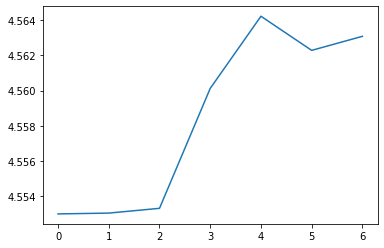

In [ ]:
line_loss = loss_calc(model_ft1, model_ft2, dataloaders_dict,bends=5)
plt.plot(line_loss)

In [ ]:
# model_th = VGGBased(num_classes, ready_weights=iter(theta))
model_th.train()
train_model(model_th, dataloaders_dict, criterion, optim.Adam(filter(lambda p: p.requires_grad, model_th.parameters())),num_epochs=4)


Epoch 0/3
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train Loss: 4.6070 Acc: 0.0152
val Loss: 4.6063 Acc: 0.0160

Epoch 1/3
----------
train Loss: 4.6030 Acc: 0.0192
val Loss: 4.6111 Acc: 0.0110

Epoch 2/3
----------
train Loss: 4.6031 Acc: 0.0192
val Loss: 4.6092 Acc: 0.0130

Epoch 3/3
----------
train Loss: 4.6088 Acc: 0.0134
val Loss: 4.6102 Acc: 0.0120

Training complete in 7m 38s
Best val Acc: 0.016000


(VGGBased(
   (conv): Sequential(
     (0): Conv2d(3, 8, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
     (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Linear(in_features=95048, out_features=100, bias=True)
     (1): Softmax(dim=None)
   )
 ),
 [tensor(0.0160, dtype=torch.float64),
  tensor(0.0110, dtype=torch.float64),
  tensor(0.0130, dtype=torch.float64),
  tensor(0.0120, dtype=torch.float64)])

In [ ]:
half1 = loss_calc(model_ft1, model_th, dataloaders_dict, bends=5)
half2 = loss_calc(model_th, model_ft2, dataloaders_dict, bends=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 line is ready
 line is ready


In [ ]:
def loss_calc_bezier(model1, model2, th1, dataloaders_dict, bends=10):
  t_list = np.linspace(0, 1, bends+2).tolist()
  line_loss=[]
  for t_id, t in enumerate(t_list):
    gen=[]
    for param1, th, param2 in zip(model1.parameters(), th1.parameters(), model2.parameters()):
      new_param=param1.data*(1-t)**2+2*t*(1-t)*th+t*t*param2.data
      gen.append(new_param)
    model_tmp = VGGBased(num_classes, from_weights=iter(gen))
    line_loss.append(loss_fun (model_tmp, dataloaders_dict, criterion,  num_epochs=1))
    del model_tmp
  return line_loss

In [ ]:

final_b_line_loss=loss_calc_bezier(model_ft1,model_ft2, model_th,dataloaders_dict)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


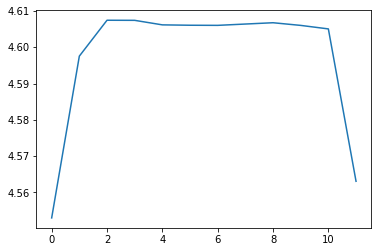

In [ ]:
final_c_line_loss=half1+half2
plt.plot(final_b_line_loss)

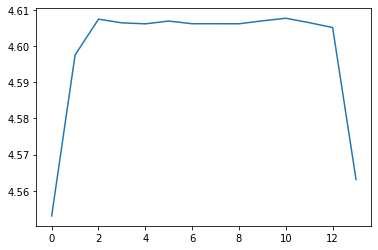

In [ ]:
plt.plot(final_c_line_loss)